# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 1/365 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [3]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

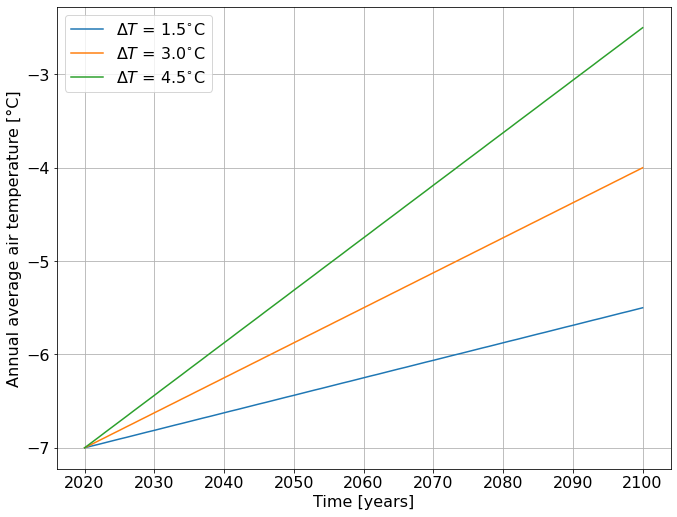

In [4]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [5]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt),(dt))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  29201


### 3. Setup Boundary Conditions

In [6]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

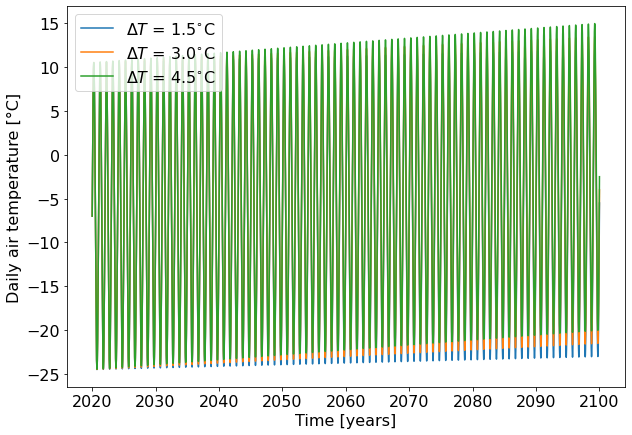

In [7]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [8]:
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

##Diffusivity

Nt = t.size #number of time steps
print('Here are the time steps: t = \n' + str(t))
print('The number of time steps: Nt = ',str(Nt))

# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(dz**2)
print('Diffusion number '+str(alpha))### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method
s = alpha*dt/(dz**2)
print('Stability criterion '+str(s))


## A Matrix
Delta2 = np.diag(-2.0*np.ones((Nz))) + np.diag(np.ones((Nz-1)),1) + np.diag(np.ones((Nz-1)),-1)
print(Delta2)

I = np.eye(Nz)
A = I - alpha*Delta2
A[0,:] = np.hstack((1.0,np.zeros((Nz-1)))) #zero out first row
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0)) #zero out last row
print(A)

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33
Here are the time steps: t = 
[2020.         2020.00273973 2020.00547945 ... 2099.99452055 2099.99726027
 2100.        ]
The number of time steps: Nt =  29201
Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.004502117402090671
Stability criterion 5.4820303221804204e-08
[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [-0.00450212  1.00900423 -0.00450212 ...  0.          0.
   0.        ]
 [ 0.         -0.00450212  1.00900423 ...  0.       

### 5. Setup Initial Condition

In [9]:
Ts0_15 = Tbottom*np.ones((Nz,1))
Ts0_30 = Tbottom*np.ones((Nz,1))
Ts0_45 = Tbottom*np.ones((Nz,1))

In [10]:
z

array([  7.5,  22.5,  37.5,  52.5,  67.5,  82.5,  97.5, 112.5, 127.5,
       142.5, 157.5, 172.5, 187.5, 202.5, 217.5, 232.5, 247.5, 262.5,
       277.5, 292.5, 307.5, 322.5, 337.5, 352.5, 367.5, 382.5, 397.5,
       412.5, 427.5, 442.5, 457.5, 472.5, 487.5])

### 7. Preallocate Storage Memory

In [11]:
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [12]:
for i in np.arange(Nt):
    if(i==0):
        Tsi_15 = Ts0_15
        
    else:
        Tsi_15 = Ts_15[:,i-1]
        Tsi_15[0] = Ttop_15[i]
        Tsi_15[-1] = Tbottom
    
    Tsip_15 = np.matmul(np.linalg.pinv(A),Tsi_15)
    
    Ts_15[:,i] = np.squeeze(Tsip_15)


In [13]:
for i in np.arange(Nt):
    if(i==0):
        Tsi_30 = Ts0_30
    else:
        Tsi_30 = Ts_30[:,i-1]
        Tsi_30[0] = Ttop_30[i]
        Tsi_30[-1] = Tbottom
        
    
    Tsip_30 = np.matmul(np.linalg.pinv(A),Tsi_30)
    
    Ts_30[:,i] = np.squeeze(Tsip_30)



In [14]:
for i in np.arange(Nt):
    if(i==0):
        Tsi_45 = Ts0_45
    else:
        Tsi_45 = Ts_45[:,i-1]
        Tsi_45[0] = Ttop_45[i]
        Tsi_45[-1] = Tbottom
        
    Tsip_45 = np.matmul(np.linalg.pinv(A),Tsi_45)
    
    Ts_45[:,i] = np.squeeze(Tsip_45)


In [15]:
#t_year2 = data[[i 10],0]
t2=t[0:(int)(10/dt)]
Ts_15_10=Ts_15[:,0:(int)(10/dt)]
Ts_30_10=Ts_30[:,0:(int)(10/dt)]
Ts_45_10=Ts_45[:,0:(int)(10/dt)]
Ts_15_10.shape



(33, 3650)

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
 

/var/folders/zj/q0y8d02s78qgbn3myfjv53vw0000gn/T/ipykernel_10189/3608685471.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt,-zz,Ts_15,cmap='inferno')
/var/folders/zj/q0y8d02s78qgbn3myfjv53vw0000gn/T/ipykernel_10189/3608685471.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt,-zz,Ts_30,cmap='inferno')
/var/folders/zj/q0y8d02s78qgbn3myfjv53vw0000gn/T/ipykernel_10189/3608685471.py:24: MatplotlibDeprecationWarning: sha

Text(0, 0.5, 'Soil depth [cm]')

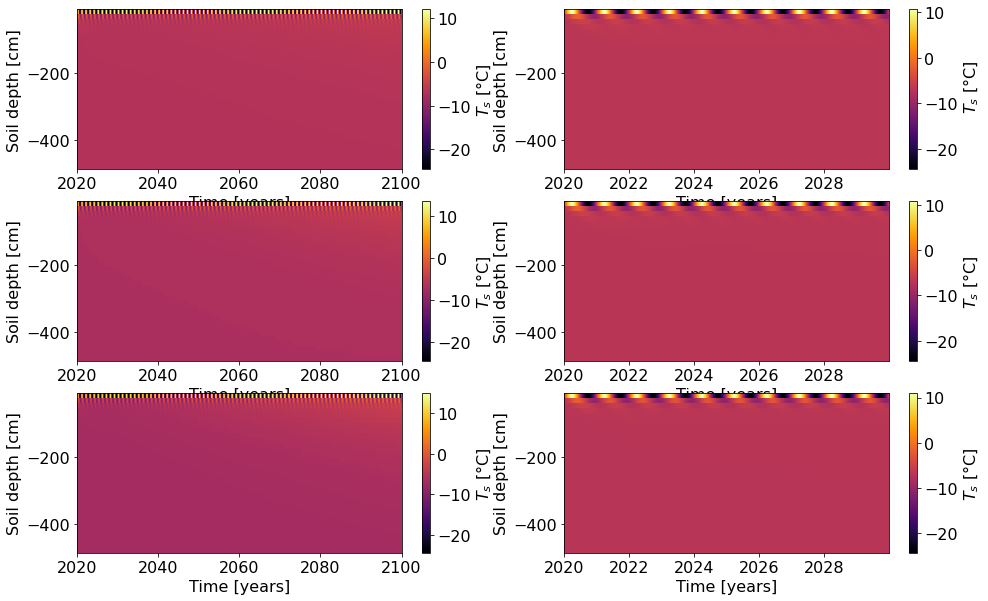

In [20]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

tt,zz = np.meshgrid(t,z)

plt.figure(figsize=(16,10)) # Create a figure and set the size

# Notice we're plotting -zz to have the top of the soil at the top and negative
# into the land surface
plt.subplot(3,2,1)
plt.pcolormesh(tt,-zz,Ts_15,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')


plt.subplot(3,2,3)
plt.pcolormesh(tt,-zz,Ts_30,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')

plt.subplot(3,2,5)
plt.pcolormesh(tt,-zz,Ts_45,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')


tt2,zz = np.meshgrid(t2,z)

plt.subplot(3,2,2)
plt.pcolormesh(tt2,-zz,Ts_15_10,cmap='inferno') 
plt.colorbar(label=' $T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')


plt.subplot(3,2,4)
plt.pcolormesh(tt2,-zz,Ts_30_10,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')

plt.subplot(3,2,6)
plt.pcolormesh(tt2,-zz,Ts_45_10,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')



2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm.

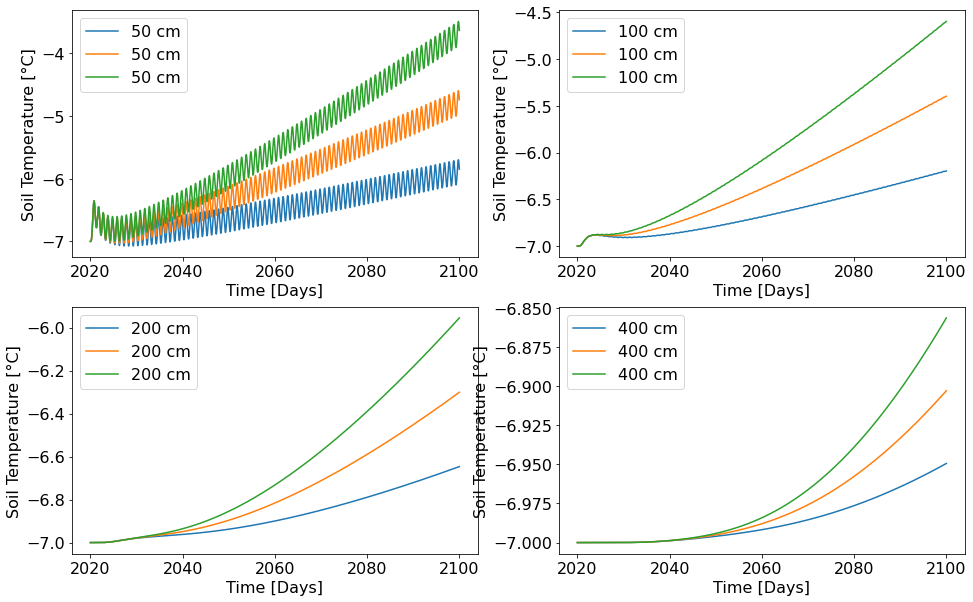

In [23]:
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()


plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(t,Ts_15[iz50,:],label='50 cm')
plt.plot(t,Ts_30[iz50,:],label='50 cm')
plt.plot(t,Ts_45[iz50,:],label='50 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
 
plt.subplot(2,2,2) 
plt.plot(t,Ts_15[iz100,:],label='100 cm')
plt.plot(t,Ts_30[iz100,:],label='100 cm')
plt.plot(t,Ts_45[iz100,:],label='100 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

plt.subplot(2,2,3) 
plt.plot(t,Ts_15[iz200,:],label='200 cm')
plt.plot(t,Ts_30[iz200,:],label='200 cm')
plt.plot(t,Ts_45[iz200,:],label='200 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

plt.subplot(2,2,4) 
plt.plot(t,Ts_15[iz400,:],label='400 cm')
plt.plot(t,Ts_30[iz400,:],label='400 cm')
plt.plot(t,Ts_45[iz400,:],label='400 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.


In [22]:
print("Values bigger than 0 =", Ts_15[Ts_15>0])
print("Their indices are ", np.nonzero(Ts_15> 0))

print("Values bigger than 0 =", Ts_15[Ts_30>0])
print("Their indices are ", np.nonzero(Ts_30> 0))

Values bigger than 0 = [0.02728913 0.30218942 0.57492629 ... 0.81937123 0.53764847 0.25413349]
Their indices are  (array([0, 0, 0, ..., 0, 0, 0]), array([   23,    24,    25, ..., 28995, 28996, 28997]))
Values bigger than 0 = [ 0.02728913  0.30218942  0.57492629 ... -0.8961606  -1.18736651
 -1.47985339]
Their indices are  (array([0, 0, 0, ..., 0, 0, 0]), array([   23,    24,    25, ..., 29001, 29002, 29003]))


Air Temp. Warming   |      2020       |       2060      | 2100
:-------------------|:---------------:|----------------:|---------------------:
   **1.5 °C**       |         0       |         3       | 10
   **3.0 °C**       |         0       |         3       | 10
   **4.5 °C**       |         0       |         3       | 10
